# Object Oriented Design Quality Metrics
<br>  

### References
- [Analyze java package metrics in a graph database](https://joht.github.io/johtizen/data/2023/04/21/java-package-metrics-analysis.html)
- [Calculate metrics](https://101.jqassistant.org/calculate-metrics/index.html)
- [jqassistant](https://jqassistant.org)
- [notebook walks through examples for integrating various packages with Neo4j](https://nicolewhite.github.io/neo4j-jupyter/hello-world.html)
- [OO Design Quality Metrics](https://api.semanticscholar.org/CorpusID:18246616)
- [Neo4j Python Driver](https://neo4j.com/docs/api/python-driver/current)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plot
from neo4j import GraphDatabase

In [2]:
# Please set the environment variable "NEO4J_INITIAL_PASSWORD" in your shell 
# before starting jupyter notebook to provide the password for the user "neo4j". 
# It is not recommended to hardcode the password into jupyter notebook for security reasons.

driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD")))
driver.verify_connectivity()

In [3]:
def get_cypher_query_from_file(cypher_file_name: str):
    with open(cypher_file_name) as file:
        return ' '.join(file.readlines())

In [4]:
def query_cypher_to_data_frame(filename : str, limit: int = 10_000):
    cypher_query_template = "{query}\nLIMIT {row_limit}"
    cypher_query = get_cypher_query_from_file(filename)
    cypher_query = cypher_query_template.format(query = cypher_query, row_limit = limit)
    records, summary, keys = driver.execute_query(cypher_query)
    return pd.DataFrame([r.values() for r in records], columns=keys)

In [5]:
def query_first_non_empty_cypher_to_data_frame(*filenames : str, limit: int = 10_000):
    """
    Executes the Cypher queries of the given files and returns the first result that is not empty.
    If all given file names result in empty results, the last (empty) result will be returned.
    By additionally specifying "limit=" the "LIMIT" keyword will appended to query so that only the first results get returned.
    """    
    result=pd.DataFrame()
    for filename in filenames:
        result=query_cypher_to_data_frame(filename, limit)
        if not result.empty:
            return result
    return result

In [6]:
#The following cell uses the build-in %html "magic" to override the CSS style for tables to a much smaller size.
#This is especially needed for PDF export of tables with multiple columns.

In [7]:
%%html
<style>
/* CSS style for smaller dataframe tables. */
.dataframe th {
    font-size: 8px;
}
.dataframe td {
    font-size: 8px;
}
</style>

## Incoming Dependencies

Incoming dependencies are also denoted as "Fan-in", "Afferent Coupling" or "in-degree".
These are the ones that use the listed package. 
   
If these packages get changed, the incoming dependencies might be affected by the change. The more incoming dependencies, the harder it gets to change the code without the need to adapt the dependent code (“rigid code”). Even worse, it might affect the behavior of the dependent code in an unwanted way (“fragile code”).

Since Java Packages are organized hierarchically, incoming dependencies can be count for every package in isolation or by including all of its sub-packages. The latter one is done without top level packages like for example "org" or "org.company" by assuring that only packages are considered that have other packages or types in the same hierarchy level ("siblings").

#### Table 1a
- Show the top 20 Java Packages with the most incoming dependencies
- Set the "incomingDependencies" properties on Package nodes.

In [8]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Incoming_Java_Package_Dependencies.cypher",
                                           "../cypher/Metrics/Set_Incoming_Java_Package_Dependencies.cypher", limit=20)

,artifactName,fullQualifiedPackageName,packageName,incomingDependencies,incomingDependenciesWeight,incomingDependentTypes,incomingDependentInterfaces,incomingDependentPackages,incomingDependentArtifacts


#### Table 1b
- Show the top 20 Java Packages including their sub-packages with the most incoming dependencies
- Set the property "incomingDependenciesIncludingSubpackages" on Package nodes.

In [9]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Incoming_Java_Package_Dependencies_Including_Subpackages.cypher",
                                           "../cypher/Metrics/Set_Incoming_Java_Package_Dependencies_Including_Subpackages.cypher", limit=20)

,artifactName,fullQualifiedPackageName,packageName,incomingDependencies,incomingDependenciesWeight,incomingDependentTypes,incomingDependentInterfaces,incomingDependentPackages,incomingDependentArtifacts


#### Table 1c
- Show the top 20 Typescript modules with the most incoming dependencies
- Set the property "incomingDependencies" on Module nodes if not already done.

In [10]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Incoming_Typescript_Module_Dependencies.cypher",
                                           "../cypher/Metrics/Set_Incoming_Typescript_Module_Dependencies.cypher", limit=20)

,fullQualifiedModuleName,moduleName,incomingDependencies,incomingDependenciesWeight,incomingDependentAbstractTypes,incomingDependentAbstractTypeWeight,incomingDependentModules,incomingDependentPackages
0,/home/runner/work/code-graph-analysis-pipeline...,router,21,42,0,0,3,2
1,/home/runner/work/code-graph-analysis-pipeline...,react-router,19,42,0,0,3,2
2,/home/runner/work/code-graph-analysis-pipeline...,react-router-dom,2,3,0,0,1,1
3,/home/runner/work/code-graph-analysis-pipeline...,react-router-dom-v5-compat,0,0,0,0,0,0
4,/home/runner/work/code-graph-analysis-pipeline...,server.tsx,0,0,0,0,0,0
5,/home/runner/work/code-graph-analysis-pipeline...,react-router-native,0,0,0,0,0,0


## Outgoing Dependencies

Outgoing dependencies are also denoted as "Fan-out", "Efferent Coupling" or "out-degree".
These are the ones that are used by the listed package. 

Code from other packages and libraries you’re depending on (outgoing) might change over time. The more outgoing changes, the more likely and frequently code changes are needed. This involves time and effort which can be reduced by automation of tests and version updates. Automated tests are crucial to reveal updates, that change the behavior of the code unexpectedly (“fragile code”). As soon as more effort is required, keeping up becomes difficult (“rigid code”). Not being able to use a newer version might not only restrict features, it can get problematic if there are security issues. This might force you to take “fast but ugly” solutions into account which further increases technical dept.

Since Java Packages are organized hierarchically, outgoing dependencies can be count for every package in isolation or by including all of its sub-packages. The latter one is done without top level packages like for example "org" or "org.company" by assuring that only packages are considered that have other packages or types in the same hierarchy level ("siblings").

#### Table 2a

- Show the top 20 Java Packages with the most outgoing dependencies
- Set the "outgoingDependencies" properties on Package nodes.

In [11]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Outgoing_Java_Package_Dependencies.cypher",
                                           "../cypher/Metrics/Set_Outgoing_Java_Package_Dependencies.cypher", limit=20)

,artifactName,fullQualifiedPackageName,packageName,outgoingDependencies,outgoingDependenciesWeight,outgoingDependentTypes,outgoingDependentInterfaces,outgoingDependentPackages,outgoingDependentArtifacts


#### Table 2b

- Show the top 20 Java Packages including their sub-packages with the most outgoing dependencies
- Set the property "outgoingDependenciesIncludingSubpackages" on Package nodes.

In [12]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Outgoing_Java_Package_Dependencies_Including_Subpackages.cypher",
                                           "../cypher/Metrics/Set_Outgoing_Java_Package_Dependencies_Including_Subpackages.cypher", limit=20)

,artifactName,fullQualifiedPackageName,packageName,outgoingDependencies,outgoingDependenciesWeight,outgoingDependentTypes,outgoingDependentInterfaces,outgoingDependentPackages,outgoingDependentArtifacts


#### Table 2c

- Show the top 20 Typescript modules with the most outgoing dependencies
- Set the "outgoingDependencies" properties on Module nodes if not already done

In [13]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Outgoing_Typescript_Module_Dependencies.cypher",
                                           "../cypher/Metrics/Set_Outgoing_Typescript_Module_Dependencies.cypher", limit=20)

,fullQualifiedModuleName,sourceName,outgoingDependencies,outgoingDependenciesWeight,outgoingDependentAbstractTypes,outgoingDependentAbstractTypeWeight,outgoingDependentModules,outgoingDependentPackages
0,/home/runner/work/code-graph-analysis-pipeline...,react-router-dom,145,362,0,0,10,2
1,/home/runner/work/code-graph-analysis-pipeline...,server.tsx,40,62,0,0,8,3
2,/home/runner/work/code-graph-analysis-pipeline...,react-router-native,24,40,0,0,7,1
3,/home/runner/work/code-graph-analysis-pipeline...,react-router,14,24,0,0,5,1
4,/home/runner/work/code-graph-analysis-pipeline...,react-router-dom-v5-compat,0,0,0,0,0,0
5,/home/runner/work/code-graph-analysis-pipeline...,router,0,0,0,0,0,0


## Instability

$$ Instability = \frac{Outgoing\:Dependencies}{Outgoing\:Dependencies + Incoming\:Dependencies} $$

*Instability* is expressed as the ratio of the number of outgoing dependencies of a module (i.e., the number of packages that depend on it) to the total number of dependencies (i.e., the sum of incoming and outgoing dependencies).

Small values near zero indicate low *Instability*. With no outgoing but some incoming dependencies the Instability is zero which is denoted as maximally stable. Such code units are more rigid and difficult to change without impacting other parts of the system. If they are changed less because of that, they are considered stable.

Conversely, high values approaching one indicate high *Instability*. With some outgoing dependencies but no incoming ones the *Instability* is denoted as maximally unstable. Such code units are easier to change without affecting other modules, making them more flexible and less prone to cascading changes throughout the system. If they are changed more often because of that, they are considered unstable.

Since Java Packages are organized hierarchically, *Instability* can be calculated for every package in isolation or by including all of its sub-packages. 

#### Table 3a

- Show the top 20 Java Packages with the lowest *Instability*
- Set the property "instability" on Package nodes. 

In [14]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Instability_for_Java.cypher",
                                           "../cypher/Metrics/Calculate_and_set_Instability_for_Java.cypher", limit=20)

,artifactName,fullQualifiedPackageName,packageName,instability,instabilityTypes,instabilityInterfaces,instabilityPackages,instabilityArtifacts,p.outgoingDependencies,p.incomingDependencies,p.outgoingDependentTypes,p.incomingDependentTypes,p.outgoingDependentInterfaces,p.incomingDependentInterfaces,p.outgoingDependentPackages,p.incomingDependentPackages,p.outgoingDependentArtifacts,p.incomingDependentArtifacts


#### Table 3b

- Show the top 20 Java Packages including their sub-packages with the lowest *Instability*
- Set the property "instabilityIncludingSubpackages" on Package nodes. 

In [15]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Instability_for_Java_Including_Subpackages.cypher",
                                           "../cypher/Metrics/Calculate_and_set_Instability_for_Java_Including_Subpackages.cypher", limit=20)

,artifactName,fullQualifiedPackageName,packageName,instability,instabilityTypes,instabilityInterfaces,instabilityPackages,instabilityArtifacts,p.outgoingDependenciesIncludingSubpackages,p.incomingDependenciesIncludingSubpackages,p.outgoingDependentTypesIncludingSubpackages,p.incomingDependentTypesIncludingSubpackages,p.outgoingDependentInterfacesIncludingSubpackages,p.incomingDependentInterfacesIncludingSubpackages,p.outgoingDependentPackagesIncludingSubpackages,p.incomingDependentPackagesIncludingSubpackages,p.outgoingDependentArtifactsIncludingSubpackages,p.incomingDependentArtifactsIncludingSubpackages


#### Table 3c

- Show the top 20 Typescript modules with the lowest *Instability*
- Set the property "instability" on Module nodes if not already done

In [16]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Instability_for_Typescript.cypher",
                                           "../cypher/Metrics/Calculate_and_set_Instability_for_Typescript.cypher", limit=20)

,projectName,fullQualifiedModuleName,moduleName,instability,instabilityAbstractTypes,instabilityModules,instabilityPackages,module.outgoingDependencies,module.incomingDependencies,module.outgoingDependentAbstractTypes,module.incomingDependentAbstractTypes,module.outgoingDependentModules,module.incomingDependentModules,module.outgoingDependentPackages,module.incomingDependentPackages
0,react-router-dom-v5-compat,/home/runner/work/code-graph-analysis-pipeline...,react-router-dom-v5-compat,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0
1,router,/home/runner/work/code-graph-analysis-pipeline...,router,0.000000,0.0,0.000000,0.000000,0,21,0,0,0,3,0,2
2,react-router,/home/runner/work/code-graph-analysis-pipeline...,react-router,0.424242,0.0,0.625000,0.333333,14,19,0,0,5,3,1,2
3,react-router-dom,/home/runner/work/code-graph-analysis-pipeline...,react-router-dom,0.986395,0.0,0.909091,0.666667,145,2,0,0,10,1,2,1
4,react-router-dom,/home/runner/work/code-graph-analysis-pipeline...,server.tsx,1.000000,0.0,1.000000,1.000000,40,0,0,0,8,0,3,0
5,react-router-native,/home/runner/work/code-graph-analysis-pipeline...,react-router-native,1.000000,0.0,1.000000,1.000000,24,0,0,0,7,0,1,0


## Abstractness

$$ Abstractness = \frac{abstract\:classes\:in\:category}{total\:number\:of\:classes\:in\:category} $$

Package *Abstractness* is expressed as the ratio of the number of abstract classes and interfaces to the total number of classes of a package.

Zero *Abstractness* means that there are no abstract types or interfaces in the package. On the other hand, a value of one means that there are only abstract types.

Since Java Packages are organized hierarchically, *Abstractness* can be calculated for every package in isolation or by including all of its sub-packages. 

#### Table 4a

- Show the top 30 packages with the lowest *Abstractness*
- Set the property "abstractness" on Package nodes. 

In [17]:
abstractness = query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Abstractness_for_Java.cypher",
                                                          "../cypher/Metrics/Calculate_and_set_Abstractness_for_Java.cypher")
abstractness.head(30)

,artifactName,fullQualifiedPackageName,packageName,abstractness,numberAbstractTypes,numberTypes


#### Table 4b

- Show the top 30 packages with the highest *Abstractness* and number of Java Types

In [18]:
abstractness.sort_values(by=['abstractness', 'numberTypes'], ascending=[False, False]).head(30)

,artifactName,fullQualifiedPackageName,packageName,abstractness,numberAbstractTypes,numberTypes


#### Table 4c

- Show the top 30 packages including their sub-packages with the highest package depth and lowest *Abstractness*
- Set the property "abstractnessIncludingSubpackages" on Package nodes. 

In [19]:
abstractnessIncludingSubpackages = query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Abstractness_for_Java_including_Subpackages.cypher",
                                                                              "../cypher/Metrics/Calculate_and_set_Abstractness_for_Java_including_Subpackages.cypher")
abstractnessIncludingSubpackages.head(30)

,artifactName,fullQualifiedPackageName,packageName,abstractness,numberAbstractTypes,numberTypes,numberOfIncludedSubPackages,maxSubpackageDepth


#### Table 4d

- Show the top 30 packages including their sub-packages with the highest package depth and highest *Abstractness*

In [20]:
abstractnessIncludingSubpackages.sort_values(by=['abstractness', 'maxSubpackageDepth', 'numberTypes'], ascending=[False, False, False]).head(30)

,artifactName,fullQualifiedPackageName,packageName,abstractness,numberAbstractTypes,numberTypes,numberOfIncludedSubPackages,maxSubpackageDepth


#### Table 4e

- Show the top 30 Typescript modules with the lowest *Abstractness*
- Set the property "abstractness" on Module nodes if not already done.

In [21]:
query_first_non_empty_cypher_to_data_frame("../cypher/Metrics/Get_Abstractness_for_Typescript.cypher",
                                           "../cypher/Metrics/Calculate_and_set_Abstractness_for_Typescript.cypher", limit=20)

,projectName,fullQualifiedModuleName,moduleName,abstractness,numberAbstractTypes,numberTypes
0,react-router-dom-v5-compat,/home/runner/work/code-graph-analysis-pipeline...,react-router-dom-v5-compat,0.000000,None,None
1,router,/home/runner/work/code-graph-analysis-pipeline...,router,0.000000,None,None
2,react-router-dom,/home/runner/work/code-graph-analysis-pipeline...,server.tsx,0.333333,None,None
3,react-router-dom,/home/runner/work/code-graph-analysis-pipeline...,react-router-dom,0.352941,None,None
4,react-router-native,/home/runner/work/code-graph-analysis-pipeline...,react-router-native,0.384615,None,None
5,react-router,/home/runner/work/code-graph-analysis-pipeline...,react-router,0.600000,None,None


## Distance from the main sequence

The *main sequence* is a imaginary line that represents a good compromise between *Abstractness* and *Instability*. A high distance to this line may indicate problems. For example is very *stable* (rigid) code with low abstractness hard to change.

Read more details on that in [OO Design Quality Metrics](https://api.semanticscholar.org/CorpusID:18246616) and [Calculate metrics](https://101.jqassistant.org/calculate-metrics/index.html).

#### Table 5a

- Show the top 30 packages with the highest distance from the "main sequence"

In [22]:
instabilityPerAbstractness = query_cypher_to_data_frame("../cypher/Metrics/Calculate_distance_between_abstractness_and_instability_for_Java.cypher")
instabilityPerAbstractness.head(30)

,artifactName,fullQualifiedName,name,distance,abstractness,instability,elementsCount


#### Table 5b

- Show the top 30 packages including their sub-packages with the highest distance from the "main sequence"

In [23]:
instabilityPerAbstractnessIncludingSubpackages = query_cypher_to_data_frame("../cypher/Metrics/Calculate_distance_between_abstractness_and_instability_for_Java_including_subpackages.cypher")
instabilityPerAbstractnessIncludingSubpackages.head(30)

,artifactName,fullQualifiedName,name,distance,abstractness,instability,elementsCount


#### Table 5c

- Show the top 30 Typescript modules with the highest distance from the "main sequence"

In [24]:
instabilityPerAbstractnessTypescript = query_cypher_to_data_frame("../cypher/Metrics/Calculate_distance_between_abstractness_and_instability_for_Typescript.cypher")
instabilityPerAbstractnessTypescript.head(30)

,artifactName,fullQualifiedName,name,distance,abstractness,instability,elementsCount
0,react-router-dom-v5-compat,/home/runner/work/code-graph-analysis-pipeline...,./index.ts,1.000000,0.000000,0.000000,0
1,router,/home/runner/work/code-graph-analysis-pipeline...,./index.ts,1.000000,0.000000,0.000000,0
2,react-router-native,/home/runner/work/code-graph-analysis-pipeline...,./index.tsx,0.384615,0.384615,1.000000,13
3,react-router-dom,/home/runner/work/code-graph-analysis-pipeline...,./index.tsx,0.339336,0.352941,0.986395,34
4,react-router-dom,/home/runner/work/code-graph-analysis-pipeline...,./server.tsx,0.333333,0.333333,1.000000,6
5,react-router,/home/runner/work/code-graph-analysis-pipeline...,./index.ts,0.024242,0.600000,0.424242,5


### *Abstractness* vs. *Instability* Plot with "Main Sequence" line as reference

- Plot *Abstractness* vs. *Instability* of all packages
- Draw the "main sequence" as dashed green diagonal line 
- Scale the packages by the number of types they contain
- Color the packages by their distance to the "main sequence" (blue=near, red=far)

In [25]:
# Function that returns the number of past (index smaller than given index) rows 
# with the same value in columnName1 and columnName2
# If there was a row with the same columnName1 and columnName2 values
# def countPastEntriesWithSameValues(dataFrame, index, columnName1, columnName2):
#     columnValue1 = dataFrame[columnName1][index]
#     columnValue2 = dataFrame[columnName2][index]
#     return len(dataFrame[
#         (dataFrame.index.isin(range(0, index + 1))) & 
#         (dataFrame[columnName1]==columnValue1) & 
#         (dataFrame[columnName2]==columnValue2)
#     ]) - 1

In [26]:
def annotate_plot(data_frame: pd.DataFrame, index: int):
    """
    Annotates the data points identified by the "index" in the plot of the "data_frame" 
    """
    x_position = data_frame.abstractness[index].item()
    y_position = data_frame.instability[index].item()
    artifact_name = data_frame.artifactName[index].item()
    package_name = data_frame.name[index].item()

    label_box=dict(boxstyle="round4,pad=0.5", fc="w", alpha=0.8)
    plot.annotate(artifact_name + '\n' + package_name
        ,xy=(x_position, y_position)
        ,xycoords='data'
        ,xytext=(20, 0)
        ,textcoords='offset points'
        ,size=6
        ,bbox=label_box
        ,arrowprops=dict(arrowstyle="-|>", mutation_scale=10, color="black")
    )

def index_of_sorted(data_frame: pd.DataFrame, highest: list[str] = []):
    """
    Sorts the "data_frame" by columns 'abstractness','instability','elementsCount', 'artifactName'
    and returns the index of the first row.
    Columns that are contained in the list of strings parameter "highest" will be sorted descending.
    """
    by = ['abstractness','instability','elementsCount','artifactName']
    ascending = [('abstractness' not in highest), ('instability' not in highest), False, True]
    return data_frame.sort_values(by=by, ascending=ascending).head(1).index

def index_of_highest_property(data_frame: pd.DataFrame, highest: str):
    """
    Sorts the "data_frame" by the property given in input parameter "highest" descending
    and returns the index of the first row.
    """
    by = [highest,'artifactName']
    ascending = [False, True]
    return data_frame.sort_values(by=by, ascending=ascending).head(1).index

In [27]:
from  matplotlib.colors import LinearSegmentedColormap

def plot_instability_per_abstractness_with_main_sequence(data_frame: pd.DataFrame, subtitle: str = ''):
    """
    Prints the so called "Main Sequence" as green dotted diagonal line as a reference.
    On top of that every Java Package is plotted as a data point:
     - The X-axis is the "Abstractness" where 0 = all classes to 1 = all interfaces and abstract classes
     - The Y-axis is the "Instability" where 0 = stable (many incoming dependencies) and 1 instable (no incoming dependencies)
     - The size reflects the number of contained Java Types
     - The color reflects the distance to the "Main Sequence"
    """
        
    colormap=LinearSegmentedColormap.from_list('rg',["green", "gold", "orangered", "red"], N=256) 
    marker_scales_bounded=data_frame.elementsCount.clip(lower=2, upper=300) * 0.7

    plot.scatter(
        data_frame.abstractness, # x axis shows abstractness
        data_frame.instability, # y axis shows instability
        s=marker_scales_bounded, # scale depends on number of contained types
        c=data_frame.distance, # color depends on distance to the main sequence
        cmap=colormap, #'bwr' # colormap that prints high values in red and lower values in blue
        alpha=0.5,
    )
    # green "main sequence" line
    plot.plot([0,1], [1,0], c='lightgreen', linestyle='dashed') 

    # Annotate largest package
    annotate_plot(data_frame, index_of_highest_property(data_frame, highest='elementsCount'))
    # Annotate largest package with the highest abstractness and instability
    annotate_plot(data_frame, index_of_sorted(data_frame, highest=['abstractness','instability']))
    # Annotate largest package with the lowest abstractness and highest instability
    annotate_plot(data_frame, index_of_sorted(data_frame, highest=['instability']))
    # Annotate largest package with the lowest abstractness and lowest instability
    annotate_plot(data_frame, index_of_sorted(data_frame, highest=[]))
    # Annotate largest package with the highest abstractness and lowest instability
    annotate_plot(data_frame, index_of_sorted(data_frame, highest=['abstractness']))
    # Annotate largest packages with the highest abstractness and instability near 0.5% 
    annotation_index = index_of_sorted(highest=['abstractness', 'instability'], data_frame=data_frame.query('abstractness <= 0.4 & instability <= 0.4'))
    annotate_plot(data_frame, annotation_index)

    plot.title('Abstractness vs. Instability ("Main Sequence")\n' + subtitle)
    plot.xlabel('Abstractness')
    plot.ylabel('Instability')
    plot.show()


#### Figure 1a - Packages without their sub-packages

In [28]:
if not instabilityPerAbstractness.empty:
   plot_instability_per_abstractness_with_main_sequence(instabilityPerAbstractness, 'Packages without their sub-packages')

#### Figure 1b - Packages including their sub-packages

In [29]:
if not instabilityPerAbstractnessIncludingSubpackages.empty:
   plot_instability_per_abstractness_with_main_sequence(instabilityPerAbstractnessIncludingSubpackages, 'Packages including their sub-packages')

#### Figure 1c - Typescript Modules

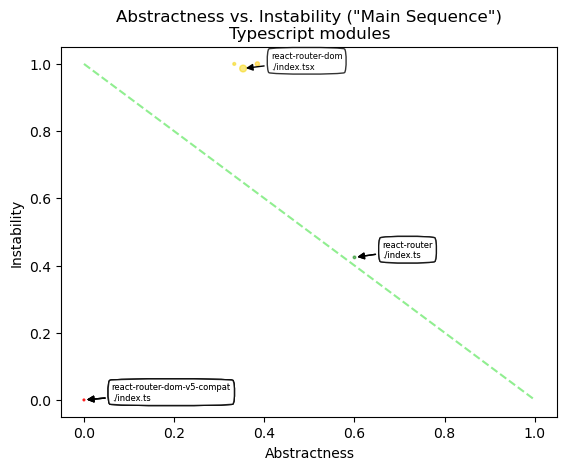

In [30]:
if not instabilityPerAbstractnessTypescript.empty:
   plot_instability_per_abstractness_with_main_sequence(instabilityPerAbstractnessTypescript, 'Typescript modules')